<a href="https://colab.research.google.com/github/rockey1006/Variational-Autoencoders/blob/master/LDF_with_Resnet%2BVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.applications.resnet import ResNet101
from keras.preprocessing import image
from keras.applications.resnet import preprocess_input
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics
import tensorflow as tf
from tensorflow import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.image import imread
from skimage.transform import resize
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
base_model = ResNet101(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

Using TensorFlow backend.














179650560/179648224 [==============================] - 6s 0us/step


#1.DownLoad the LFW dataset and Split into a training set and a test set 


In [3]:
print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')


# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=0, resize=0.5)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

2020-01-12 03:06:21,585 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012


Automatically created module for IPython interactive environment


2020-01-12 03:06:21,853 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2020-01-12 03:06:22,211 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2020-01-12 03:06:22,489 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


Total dataset size:
n_samples: 13233
n_features: 2914
n_classes: 5749


#2.Resize the image to (224,224,3) in order to feed to the restnet

In [0]:
def resize_image(img):
    img = resize(img, (224, 224,3), anti_aliasing=True)
    return img

def rescale_image(img):
    return img /255

#First resize...
x_train = [resize_image(i) for i in X_train]
x_test = [resize_image(i) for i in X_test]


In [5]:
print(x_train[0].shape)


(224, 224, 3)


#3.Extract the feature vectors(1,2048) from the resnet 101




In [0]:
features=[]
for i, element in enumerate(x_train):
  x = image.img_to_array(element)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)

  features.append(model.predict(x))

In [0]:
features_test=[]
for i, element in enumerate(x_test):
  x = image.img_to_array(element)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  features_test.append(model.predict(x))

#3.Resize the image size to (9924, 2048) and (3309, 2048) to feed the VAE


In [10]:
x_train = np.array(features) 
print(x_train.shape)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
print(x_train.shape)

(9924, 1, 2048)
(9924, 2048)


In [11]:
x_test = np.array(features_test) 
print(x_test.shape)
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))#改变shape
print(x_test.shape)

(3309, 1, 2048)
(3309, 2048)


# 4.Define the VAE

In [16]:
batch_size = 10
original_dim = 2048
latent_dim = 2
intermediate_dim = 256
epochs = 5
epsilon_std = 1.0
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)#
z_mean = Dense(latent_dim)(h)#
z_log_var = Dense(latent_dim)(h)
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])#
decoder_h = Dense(intermediate_dim, activation='relu')#
decoder_mean = Dense(original_dim, activation='sigmoid')#
h_decoded = decoder_h(z)#
x_decoded_mean = decoder_mean(h_decoded)#
vae = Model(x, x_decoded_mean)
#model = Model(inputs=[a1, a2], outputs=[b1, b3, b3])

# Compute VAE loss
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) #
vae_loss = K.mean(xent_loss + kl_loss)

vae.add_loss(vae_loss) 
vae.compile(optimizer='rmsprop') #

#compile(self, optimizer, loss, metrics=None, loss_weights=None, sample_weight_mode=None, 
#weighted_metrics=None, target_tensors=None)

vae.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 256)          524544      input_4[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 2)            514         dense_11[0][0]                   
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 2)            514         dense_11[0][0]                   
____________________________________________________________________________________________

#5.VAE Training

In [17]:
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        verbose=2,
        validation_data=(x_test, None))

Train on 9924 samples, validate on 3309 samples
Epoch 1/5
 - 17s - loss: -2.9874e+03 - val_loss: -3.0968e+03
Epoch 2/5
 - 15s - loss: -3.1061e+03 - val_loss: -3.0188e+03
Epoch 3/5
 - 15s - loss: -3.1210e+03 - val_loss: -3.1386e+03
Epoch 4/5
 - 15s - loss: -3.1270e+03 - val_loss: -3.1370e+03
Epoch 5/5
 - 15s - loss: -3.0767e+03 - val_loss: -3.1483e+03


#6. Display a 2D plot of the digit classes in the latent space


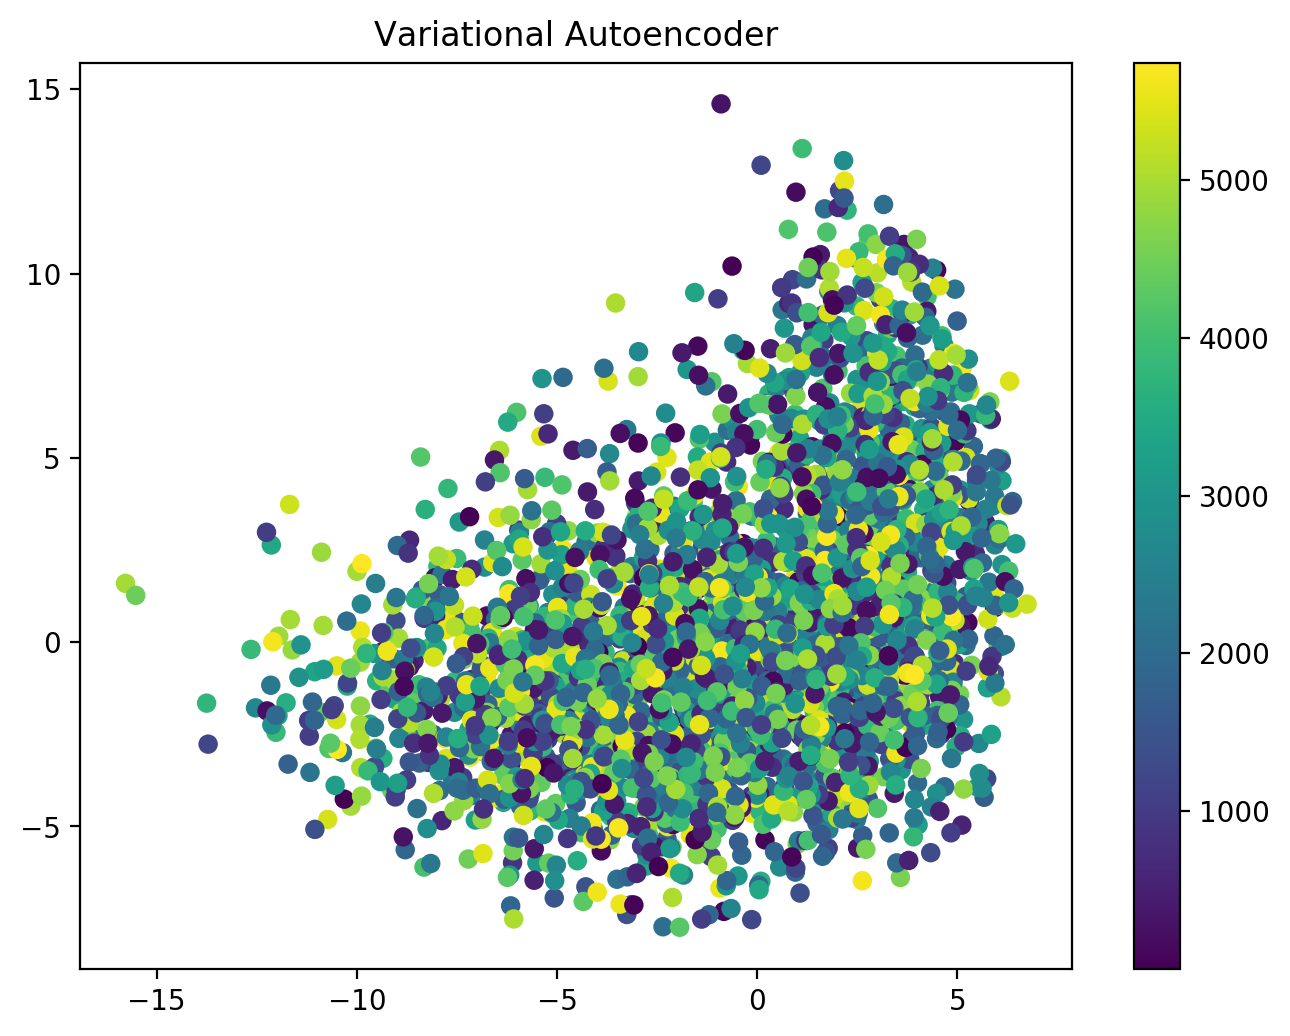

In [19]:
encoder = Model(x, z_mean)
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(8, 6), dpi=200)#Create a new figure.
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1],c=y_test)
plt.title('Variational Autoencoder')
plt.colorbar()
plt.show()
##13233 images
#5749 people
#